In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

In [261]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error

In [262]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [263]:
df = pd.read_csv('personal_website_stats.csv', parse_dates=['timestamp'], date_format='%Y-%m-%d')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns = ['date', 'page_views', 'ad_spend', 'weekend', 'day', 'holiday']
df = df.set_index('date')
df.index.freq='D'
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2022-01-01 to 2024-12-31
Freq: D
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   page_views  1096 non-null   float64
 1   ad_spend    1096 non-null   float64
 2   weekend     1096 non-null   bool   
 3   day         1096 non-null   object 
 4   holiday     1096 non-null   bool   
dtypes: bool(2), float64(2), object(1)
memory usage: 36.4+ KB


In [264]:
df.head()

,page_views,ad_spend,weekend,day,holiday
date,,,,,
2022-01-01,1165.962767,194.901425,True,Saturday,True
2022-01-02,1191.485835,175.852071,True,Sunday,False
2022-01-03,1266.928269,269.430656,False,Monday,False
2022-01-04,1364.193858,295.690896,False,Tuesday,False
2022-01-05,1013.282520,242.975399,False,Wednesday,False


In [265]:
df = pd.get_dummies(df, dtype=float)
bool_columns = ['weekend', 'holiday']
df[bool_columns] = df[bool_columns].astype(float)

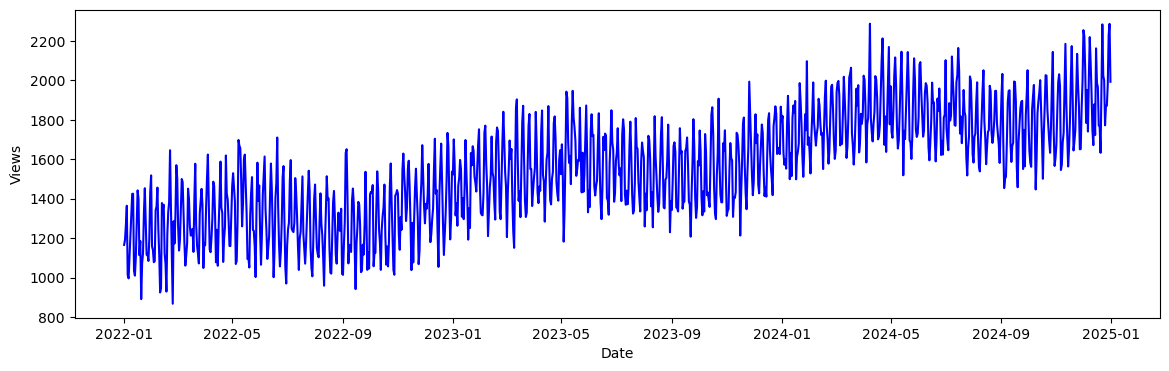

In [266]:
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['page_views'], label='Train Data', color='blue')
plt.ylabel('Views')
plt.xlabel('Date')
plt.show()

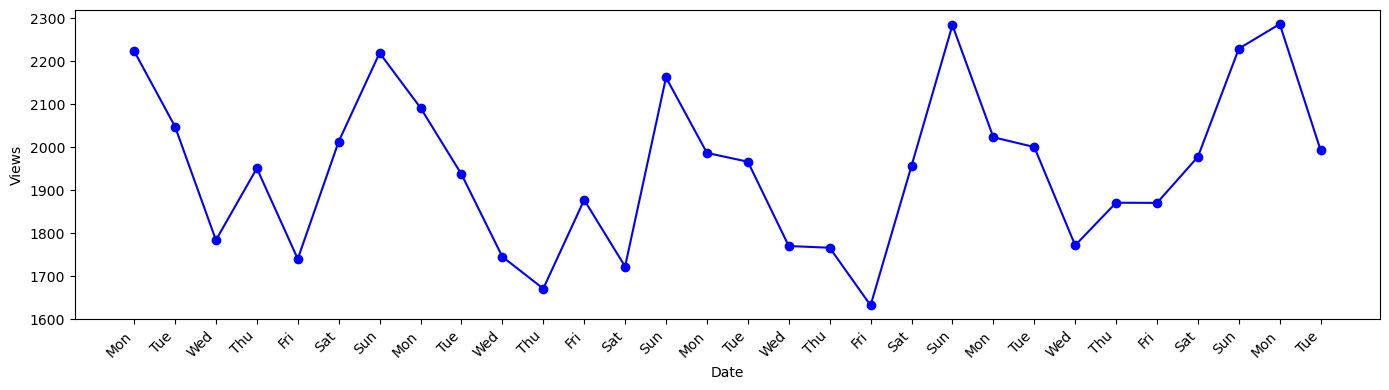

In [267]:
df2 = df.iloc[1066:,:].copy()        
df2['day'] = df2.index.strftime('%a')  
df2 = df2.reset_index(drop=True)       
df2['day_num'] = df2.index             

plt.figure(figsize=(14, 4))
plt.plot(df2['day_num'], df2['page_views'], label='Train Data', color='blue', marker='o')
plt.ylabel('Views')
plt.xlabel('Date')
plt.xticks(ticks=df2['day_num'], labels=df2['day'], rotation=45, ha='right')

#plt.legend()
plt.tight_layout()
plt.show()

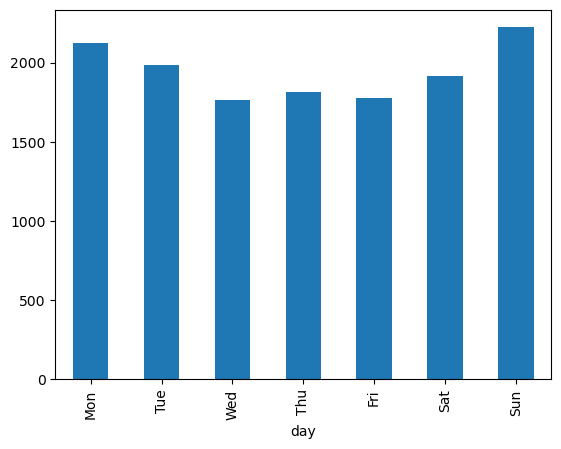

In [268]:
mean_by_day = df2.groupby('day')['page_views'].mean()
days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
mean_by_day = mean_by_day.reindex(days_order)
mean_by_day.plot(kind='bar')
plt.show()

### Test for Stationarity

In [269]:
adf_result = adfuller(df['page_views'], regression='c')
print(f"Initial ADF Test P-value: {adf_result[1]:.4f} (Expected <= 0.05 for Stationarity")

df1d = df['page_views'].diff(periods=1)
df1d = df1d.dropna()

adf_result = adfuller(df1d, regression='c')
print(f"ADF Test P-value: {adf_result[1]:.4f} (Expected <= 0.05 for Stationarity)")

Initial ADF Test P-value: 0.8789 (Expected <= 0.05 for Stationarity
ADF Test P-value: 0.0000 (Expected <= 0.05 for Stationarity)


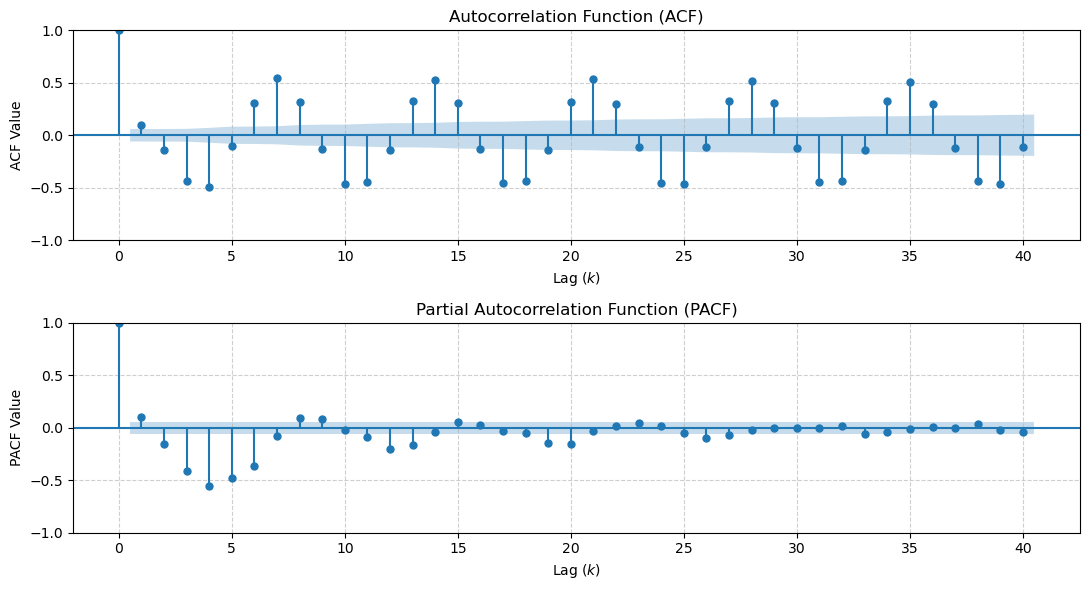

In [270]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharex=False)
plot_acf(df1d, ax=axes[0], lags=40, alpha=0.05, title='Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag ($k$)')
axes[0].set_ylabel('ACF Value')
axes[0].grid(True, linestyle='--', alpha=0.6)

plot_pacf(df1d, ax=axes[1], lags=40, alpha=0.05, method='ywmle', title='Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag ($k$)')
axes[1].set_ylabel('PACF Value')
axes[1].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [271]:
train = df[:-30]
test = df[-30:]
y_train = train['page_views']
y_test = test['page_views']

X_train = train.drop(['page_views'], axis=1)
X_test = test.drop(['page_views'], axis=1)

In [272]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1066 entries, 2022-01-01 to 2024-12-01
Freq: D
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ad_spend       1066 non-null   float64
 1   weekend        1066 non-null   float64
 2   holiday        1066 non-null   float64
 3   day_Friday     1066 non-null   float64
 4   day_Monday     1066 non-null   float64
 5   day_Saturday   1066 non-null   float64
 6   day_Sunday     1066 non-null   float64
 7   day_Thursday   1066 non-null   float64
 8   day_Tuesday    1066 non-null   float64
 9   day_Wednesday  1066 non-null   float64
dtypes: float64(10)
memory usage: 91.6 KB


In [273]:
from pmdarima import auto_arima
def arima_model(m_try):
    auto_model = auto_arima(y_train, 
        start_p=0, d=None, start_q=0, 
        max_p=2, max_d=2, max_q=2,
        start_P=0, D=None, start_Q=0, 
        max_P=2, max_D=2, max_Q=2,
        max_order=6, m=m_try, stepwise=True, trace=False, information_criterion='bic')

    train_pred = auto_model.predict_in_sample()
    test_pred = auto_model.predict(n_periods=30)

    rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
    print(auto_model.summary())
    print()
    print('Train RMSE:  ', rmse_train, 'm = ', m_try)
    print('Test RMSE:  ', rmse_test, 'm = ', m_try)

In [274]:
#arima_model(7)

In [275]:
#arima_model(4)

In [276]:
from pmdarima import auto_arima
def arima_model_x(m_try):
    auto_model = auto_arima(y_train, X=X_train,
        start_p=0, d=None, start_q=0, 
        max_p=2, max_d=2, max_q=2,
        start_P=0, D=None, start_Q=0, 
        max_P=2, max_D=2, max_Q=2,
        max_order=8, m=m_try, stepwise=True, trace=True, information_criterion='bic', error_action='ignore')

    train_pred = auto_model.predict_in_sample(X=X_train)
    test_pred = auto_model.predict(n_periods=30, X=X_test)

    mse_train = root_mean_squared_error(y_train, train_pred)
    mse_test = root_mean_squared_error(y_test, test_pred)
    print(auto_model.summary())
    print()
    print('Train RMSE:  ', mse_train, 'm = ', m_try)
    print('Test RMSE:  ', mse_test, 'm = ', m_try)

In [277]:
arima_model_x(4)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : BIC=13170.568, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : BIC=12930.099, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : BIC=12652.744, Time=3.83 sec
 ARIMA(0,1,0)(0,0,0)[4]             : BIC=13163.654, Time=1.79 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : BIC=12654.406, Time=2.80 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : BIC=12657.979, Time=5.39 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : BIC=12658.663, Time=5.59 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : BIC=12653.336, Time=4.55 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : BIC=12666.101, Time=5.89 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : BIC=13169.802, Time=0.70 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : BIC=12651.053, Time=4.62 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : BIC=12650.296, Time=2.98 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : BIC=12651.316, Time=2.57 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : BIC=12657.336, Time=3.35 sec
 ARIMA(1,1,0)(0,0,0

In [290]:
X_test = X_test.loc[:,['ad_spend']].copy()
X_train = X_train.loc[:,['ad_spend']].copy()
X_test.shape, X_train.shape

((30, 1), (1066, 1))

In [291]:
X_test.shape

(30, 1)

In [292]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1066 entries, 2022-01-01 to 2024-12-01
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ad_spend  1066 non-null   float64
dtypes: float64(1)
memory usage: 48.9 KB


In [224]:
from pmdarima import auto_arima
def arima_model(m_try):
    auto_model = auto_arima(y_train, X=X_train,
        start_p=0, d=None, start_q=0, 
        max_p=2, max_d=2, max_q=2,
        start_P=0, D=None, start_Q=0, 
        max_P=2, max_D=2, max_Q=2,
        max_order=8, m=m_try, stepwise=True, trace=True, information_criterion='bic', error_action='ignore')

    train_pred = auto_model.predict_in_sample(X=X_train)
    test_pred = auto_model.predict(n_periods=30, X=X_test)

    mse_train = root_mean_squared_error(y_train, train_pred)
    mse_test = root_mean_squared_error(y_test, test_pred)
    print(auto_model.summary())
    print()
    print('Train RMSE:  ', mse_train, 'm = ', m_try)
    print('Test RMSE:  ', mse_test, 'm = ', m_try)

In [225]:
arima_model(7)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=13958.751, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=13467.708, Time=0.88 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=13589.284, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=13951.821, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=13954.273, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : BIC=13294.625, Time=1.69 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : BIC=inf, Time=2.38 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : BIC=13480.898, Time=0.91 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : BIC=13208.269, Time=3.62 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : BIC=13394.882, Time=0.80 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : BIC=inf, Time=2.74 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : BIC=inf, Time=2.26 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : BIC=inf, Time=2.55 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : BIC=inf, Ti

In [223]:
arima_model(4)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : BIC=13958.751, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : BIC=13614.816, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : BIC=13603.785, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[4]             : BIC=13951.821, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : BIC=13950.968, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : BIC=13387.735, Time=1.07 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : BIC=13382.525, Time=0.71 sec
 ARIMA(0,1,1)(2,0,0)[4] intercept   : BIC=13386.490, Time=1.06 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : BIC=13144.929, Time=1.73 sec
 ARIMA(0,1,1)(2,0,2)[4] intercept   : BIC=inf, Time=2.36 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : BIC=13366.775, Time=1.80 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : BIC=13587.970, Time=1.41 sec
 ARIMA(1,1,1)(2,0,1)[4] intercept   : BIC=13143.320, Time=2.05 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : BIC=13312.036, Time=1.30 sec
 ARIMA(1,1,1)(2,0,0)[4] i

In [293]:
X_train.shape

(1066, 1)

In [294]:
model = SARIMAX(y_train, exog=X_train, order=(2, 1, 1), seasonal_order=(2,0,1,4))
results = model.fit(maxiter=1000)
results.summary()

E:\anaconda3\envs\pyarima\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\anaconda3\envs\pyarima\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        page_views   No. Observations:                 1066
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 4)   Log Likelihood               -6541.816
Date:                           Fri, 31 Oct 2025   AIC                          13099.632
Time:                                   22:17:38   BIC                          13139.398
Sample:                               01-01-2022   HQIC                         13114.700
                                    - 12-01-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ad_spend       0.3319      0.040      8.317      0.000       0.254       0.410
ar.L1          0.0873      0.041      2.134      0.033       0.007       0.167
ar.L2         -0.1133      0.036     -3.145      0.002      -0.184      -0.043
ma.L1         -0.8560      0.024    -35.129      0.000      -0.904      -0.808
ar.S.L4       -1.5734      0.025    -61.822      0.000      -1.623      -1.524
ar.S.L8       -0.7459      0.024    -31.605      0.000      -0.792      -0.700
ma.S.L4        0.8920      0.021     43.219      0.000       0.852       0.932
sigma2      1.258e+04    553.244     22.736      0.000    1.15e+04    1.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.55   Prob(JB):                         0.95
Heteroskedasticity (H):               0.91   Skew:                             0.02
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

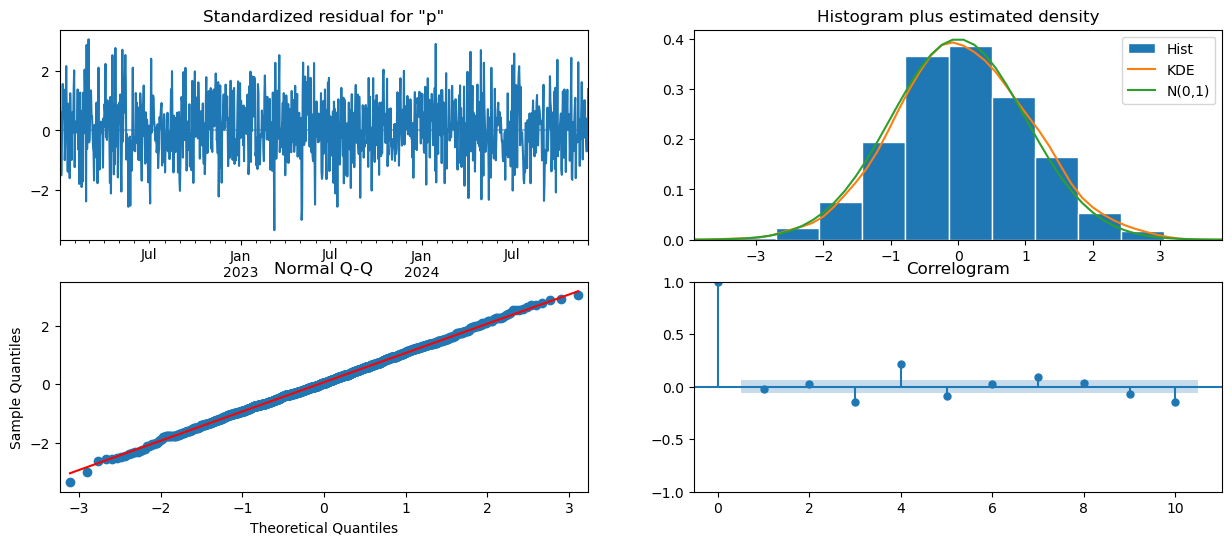

In [295]:
results.plot_diagnostics(figsize=(15,6))
plt.show()

In [296]:
train_pred = results.predict(start=0, end=len(y_train)-1, exog=X_train)
test_pred = results.forecast(steps=30, exog=X_test)

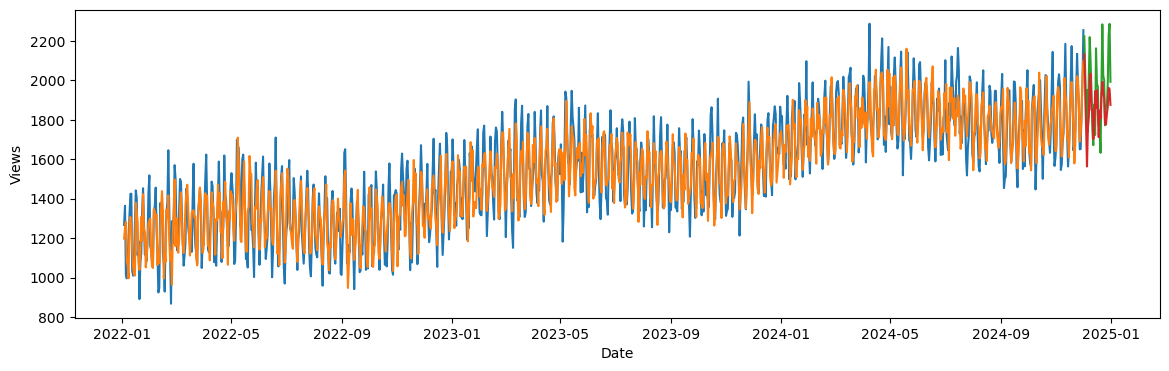

In [302]:
plt.figure(figsize=(14, 4))
plt.plot(y_train[2:,], label='Train')
plt.plot(train_pred[2:,], label='Train Pred')
plt.plot(y_test, label='Test')
plt.plot(test_pred, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Views')
#plt.legend()
plt.show()

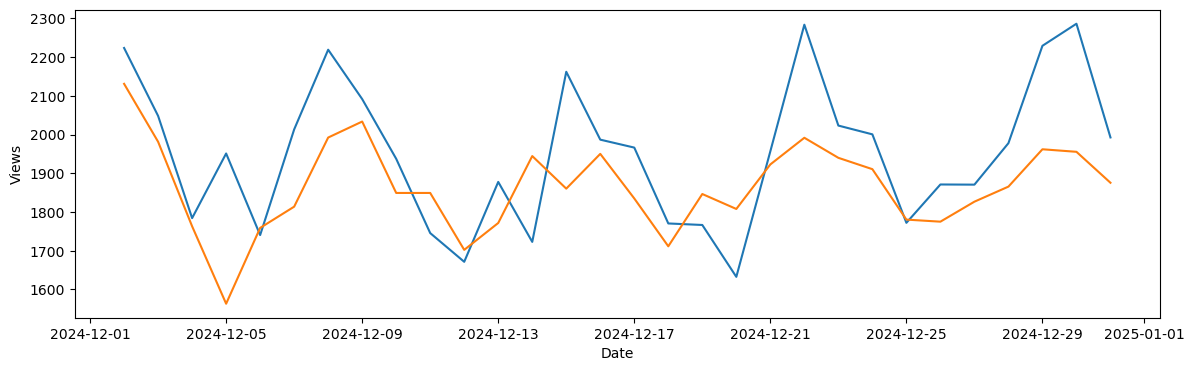

In [303]:
plt.figure(figsize=(14, 4))
plt.plot(y_test)
plt.plot(test_pred)
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()

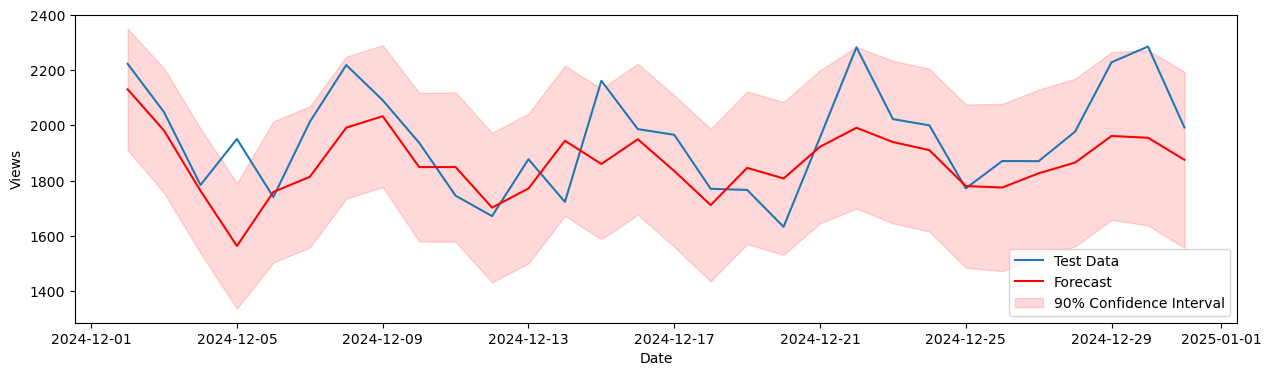

In [305]:
forecast_result = results.get_forecast(steps=30, exog=X_test, alpha=0.1)
test_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int() # This returns a DataFrame/array with lower and upper bounds
lower_ci = conf_int.iloc[:, 0]
upper_ci = conf_int.iloc[:, 1]

plt.figure(figsize=(15, 4))
plt.plot(y_test, label='Test Data')
plt.plot(test_pred, label='Forecast', color='red')
plt.fill_between(test.index, lower_ci, upper_ci, color='r', alpha=0.15, label='90% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.show()

In [306]:
from sklearn.metrics import root_mean_squared_error
mse_train = root_mean_squared_error(y_train, train_pred)
mse_test = root_mean_squared_error(y_test, test_pred)
print('Train RMSE:  ', mse_train)
print('Test RMSE:  ', mse_test)

Train RMSE:   117.49741032172783
Test RMSE:   164.17534690890741


In [307]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_actual, y_pred, set_name):
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    return {'Set': set_name, 'MAE': mae,'MAPE(%)': mape, 'RMSE': rmse}

# Calculate metrics for both sets
train_metrics = calculate_metrics(y_train, train_pred, 'Train')
test_metrics = calculate_metrics(y_test, test_pred, 'Test')

# --- 4. Create and Present the Results Table ---
results_df = pd.DataFrame([train_metrics, test_metrics])

# Format the numerical columns for better readability
results_df['MAE'] = results_df['MAE'].map('{:.2f}'.format)
results_df['RMSE'] = results_df['RMSE'].map('{:.2f}'.format)
results_df['MAPE(%)'] = results_df['MAPE(%)'].map('{:.2f}'.format)


print(results_df.set_index('Set'))

          MAE MAPE(%)    RMSE
Set                          
Train   90.66    0.06  117.50
Test   129.33    0.06  164.18
